In [32]:
import os
from multiprocessing import Pool, cpu_count

import pandas as pd
from Bio.PDB import DSSP, MMCIFParser, PDBParser
from tqdm import tqdm

In [33]:
NATURE_PATH = "data/compare/plddt/Nature"
P450DIFFUSION_PATH = "data/compare/plddt/P450Diffusion"
P450DIFF2_PATH = "data/compare/plddt/P450Diff2"

In [34]:
def get_residue_structure(structure_file, dssp_executable="mkdssp"):
    """读取结构文件并运行 DSSP"""
    structure_id = os.path.basename(structure_file).split(".")[0]
    file_ext = os.path.splitext(structure_file)[-1].lower()

    if file_ext == ".cif":
        parser = MMCIFParser(QUIET=True)
    elif file_ext == ".pdb":
        parser = PDBParser(QUIET=True)
    else:
        raise ValueError(f"Unsupported file type: {file_ext}")

    structure = parser.get_structure(structure_id, structure_file)
    model = structure[0]
    dssp = DSSP(model, structure_file, dssp=dssp_executable)
    return dssp


structure_mapping = {
    "H": "Alphahelix",
    "B": "Betabridge",
    "E": "Strand",
    "G": "3-10Helix",
    "I": "PiHelix",
    "T": "Turn",
    "S": "Bend",
    "-": "Loop",
}


def process_structure(file_path):
    try:
        dssp = get_residue_structure(file_path)
        ss_list = [dssp[key][2] for key in dssp.keys()]
        total = len(ss_list)

        ss_count = {}
        for code in ss_list:
            readable = structure_mapping.get(code, "Unknown")
            ss_count[readable] = ss_count.get(readable, 0) + 1

        ss_percent = {k: v / total * 100 for k, v in ss_count.items()}
        ss_percent["Filename"] = os.path.basename(file_path)
        ss_percent["Path"] = file_path
        return ss_percent
    except Exception as e:
        return {
            "Filename": os.path.basename(file_path),
            "Path": file_path,
            "Error": str(e),
        }


def analyze_structures_recursively(root_dir, n_processes=None):
    """多进程分析所有结构文件"""
    if n_processes is None:
        n_processes = max(1, cpu_count() - 1)

    file_list = []
    for dirpath, _, filenames in os.walk(root_dir):
        for file in filenames:
            if file.endswith((".pdb", ".cif")):
                file_list.append(os.path.join(dirpath, file))

    with Pool(processes=n_processes) as pool:
        results = list(
            tqdm(
                pool.imap_unordered(process_structure, file_list), total=len(file_list)
            )
        )

    df = pd.DataFrame(results)
    df.fillna(0, inplace=True)
    return df

In [35]:
dfNature = analyze_structures_recursively(NATURE_PATH, n_processes=19)
dfP450Diffusion = analyze_structures_recursively(P450DIFFUSION_PATH, n_processes=19)
dfP450Diff2 = analyze_structures_recursively(P450DIFF2_PATH, n_processes=19)

100%|██████████| 12800/12800 [04:33<00:00, 46.79it/s]


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

In [37]:
dfNature["source"] = "Nature"
dfP450Diffusion["source"] = "P450Diffusion"
dfP450Diff2["source"] = "P450Diff2"

# 合并所有 DataFrame
df_all = pd.concat([dfNature, dfP450Diffusion, dfP450Diff2], ignore_index=True)

In [38]:
df_melted = df_all.melt(
    id_vars=["source"],
    value_vars=[
        "Alphahelix",
        "Betabridge",
        "Strand",
        "3-10Helix",
        "PiHelix",
        "Turn",
        "Bend",
        "Loop",
    ],
    var_name="Secondary structure",
    value_name="Percentage(%)",
)

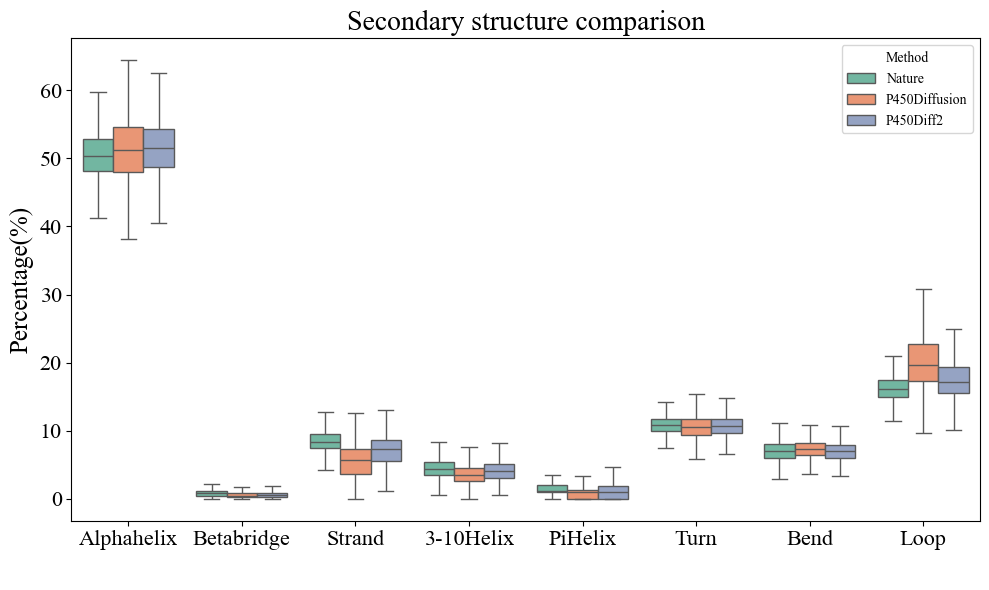

In [40]:
# 画箱线图
plt.figure(figsize=(10, 6))
FONT_PATH = "data/font/Times New Roman.ttf"
font_prop = font_manager.FontProperties(fname=FONT_PATH)

sns.boxplot(
    x="Secondary structure",
    y="Percentage(%)",
    hue="source",
    data=df_melted,
    palette="Set2",
    showfliers=False,
)
plt.title("Secondary structure comparison", fontproperties=font_prop, fontsize=20)
plt.ylabel("Percentage(%)", fontproperties=font_prop, fontsize=18)
plt.xlabel(" ", fontproperties=font_prop, fontsize=18)
plt.xticks(fontproperties=font_prop, fontsize=16)
plt.yticks(fontproperties=font_prop, fontsize=16)
plt.legend(title="Method", prop=font_prop, title_fontproperties=font_prop)
plt.tight_layout()
plt.savefig("data/pic/dssp_distribution.png", dpi=300)
plt.show()